# Solution Assignment 1: Backpropagation and Gradient Descent

This is the solution of the first assignment of the Implementing Artificial Neural Networks with TensorFlow course. Please find the according assignment sheet on studip.

## 1. The backpropagation algorithm

### 1.1 Write down the network function

$y = \sigma(\sigma(\sigma(\bar{x}^TW)W)\bar{w})$

### 1.2 Insert the network-function into the _Sum Squared Error Function_

The _Sum Squared Error Function_ is defined as, $loss = \sum_j\frac{1}{2}(\hat{y_j}-y_j)^2$. Where $y$ denotes the network's output, $\bar{x_j}$ the network input and $\hat{y}$ the label (target value) of $\bar{x_j}$. Hence, we get the following formula, if we insert the network-function into the _Sum Squared Error Function_:

$loss = \sum_j\frac{1}{2}(\hat{y_j}-\sigma(\sigma(\sigma(\bar{x_j}^TW)W)\bar{w}))^2$


### 1.3 Calculate the gradient of the loss function with respect to $\bar{w}_{out}$

$
\begin{align}
\nabla_{\bar{w_3}} loss &= \nabla_{\bar{w_3}} \sum_j\frac{1}{2}(\hat{y_j}-y_j)^2\\
&= \sum_j \nabla_{\bar{w_3}}\frac{1}{2}(\hat{y}-y)^2\\
&= \sum_j (\hat{y_j}-y_j) \nabla_{\bar{w_3}}\hat{y}-y\\
&= \sum_j (\hat{y_j}-y_j) \nabla_{\bar{w_3}}-\sigma(\bar{a_2}\bar{w_3})\\
&= \sum_j (\hat{y_j}-y_j) (-\sigma'(\bar{a_2}\bar{w_3})) \nabla_{\bar{w_3}} \bar{a_2}\bar{w_3}\\
&= \sum_j (\hat{y_j}-y_j) (-\sigma'(\bar{a_2}\bar{w_3})) \bar{a_2}\\
\end{align}
$

### 1.4 The derivative of the Logistic Function

The _quotient rule_ of calculus states, that the derivative of a function, which is defined as the ratio of two functions $f(x) = \frac{g(x)}{h(x)}$ is defined as $f'(x) = \frac{g'(x)h(x)-g(x)h'(x)}{h(x)^2}$.

The Logistic Function $\sigma(x) = \frac{1}{1+e^{-x}}$ is exactly of this form and hence, we can derive

$
\begin{align}
\sigma'(x) &= \frac{\delta}{\delta x} \frac{1}{1+e^{-x}}\\
&= \frac{(0\cdot e^{-x})-(1\cdot -e^{-x})}{(1+e^{-x})^2}\\
&= \frac{e^{-x}}{(1+e^{-x})^2}
\end{align}
$

Another notation that you can find quite frequently is $\sigma'(x) = \sigma(x)(1 - \sigma(x))$. It can be derived in the following way:

$
\begin{align}
\sigma'(x) &= \frac{\delta}{\delta x} \frac{1}{1+e^{-x}} \frac{e^x}{e^x}\\
&= \frac{\delta}{\delta x} \frac{e^x}{e^x+e^0}\\
&= \frac{\delta}{\delta x} \frac{e^x}{1+e^x}\\
&= \frac{e^x(1+e^x)-e^xe^x}{(1+e^x)^2}\\
&= \frac{e^x+e^{2x}-e^{2x}}{(1+e^x)^2}\\
&= \frac{e^x}{(1+e^x)^2}\\
&= \frac{e^x}{1+e^x}\frac{1}{1+e^x}\\
&= \sigma(x)(1-\sigma(x))
\end{align}
$

since

$
\begin{align}
(1-\sigma(x)) &= 1-\frac{e^x}{1+e^{x}}\\
&= \frac{1+e^x}{1+e^x}-\frac{e^x}{1+e^{x}}\\
&= \frac{1}{1+e^x}
\end{align}
$





## 2. Cats and Dogs
Next, we are going to implement the very simple network, with only two input values, two weights and a single output neuron and visualize the error surface and the training progress.

![IMAGE MISSING](./simple-ann.png)

### 2.1 Imports
We are going to use `numpy` for the numerical computations and `matplotlib` to plot the training process of the network. Further, we activate inline plotting by calling `%matplotlib notebook`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import sleep

%matplotlib notebook

### 2.2 Training data
First, lets generate our training data. We sample both, the cat and the dog data from a 2-D normal distribution.

In [2]:
sample_size = 30

np.random.seed(1)
cats = np.random.normal(25, 5, (2, sample_size))
dogs = np.random.normal(45, 15, (2, sample_size))

### 2.3 Investigating the data

<IPython.core.display.Javascript object>


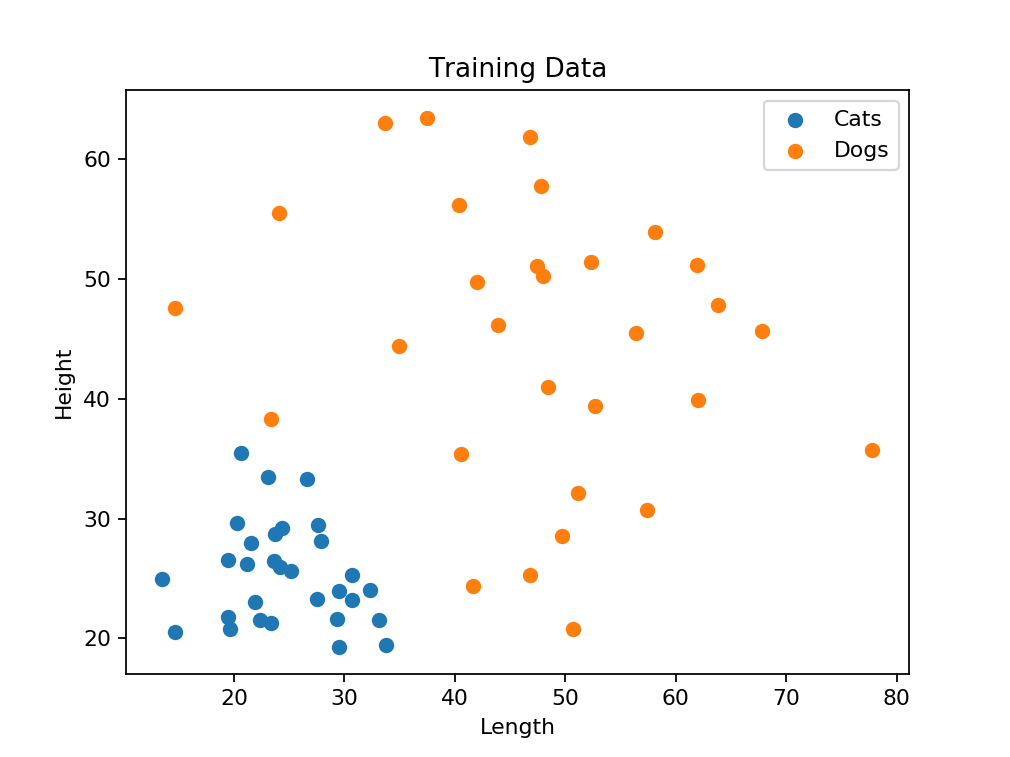

In [3]:
fig, ax = plt.subplots()

ax.scatter(cats[0], cats[1], label = "Cats")
ax.scatter(dogs[0], dogs[1], label = "Dogs")

ax.set_title("Training Data")
ax.set_xlabel("Length")
ax.set_ylabel("Height")

ax.legend()

It seems like the data is linear seperable, hence, a single artificial neuron should be able to learn the task perfectly. In other words, we should be able to reduce the loss to 0. However, our network does not contain a bias term and therefore, the network can only rotate the separation line around the origin and can not shift it up and downwards. As a result, the network will not be able to learn the task, if we do not normalize the data!

<IPython.core.display.Javascript object>


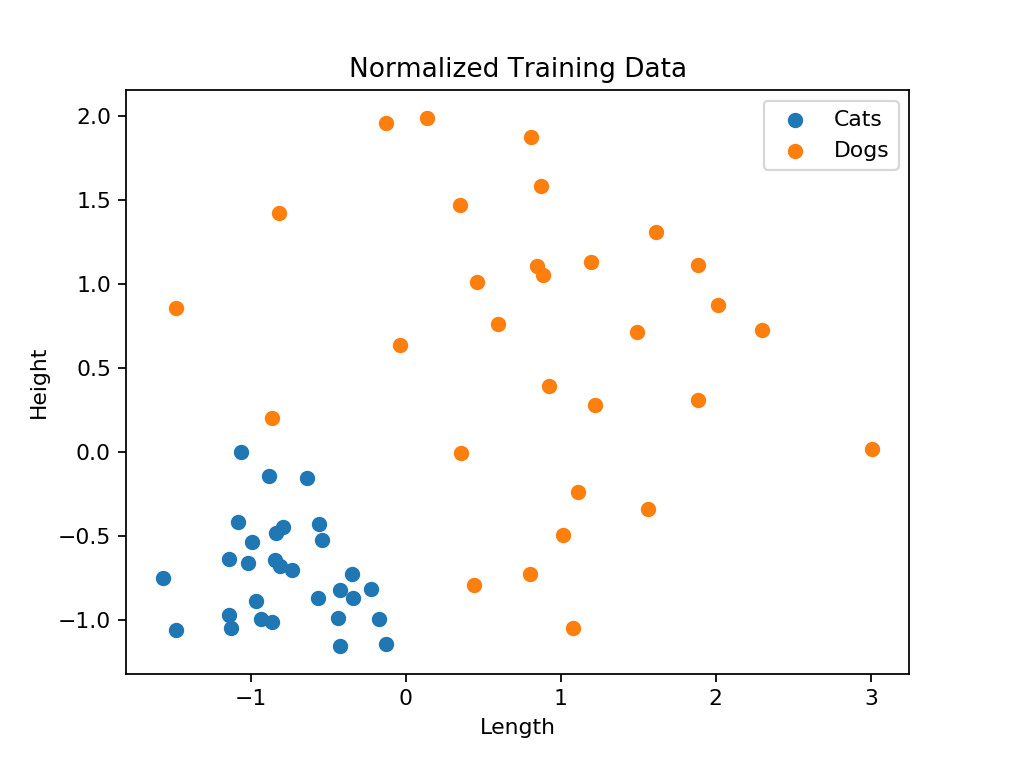

In [4]:
cats_and_dogs = np.concatenate([cats, dogs])
cats = (cats - np.mean(cats_and_dogs)) / np.std(cats_and_dogs)
dogs = (dogs - np.mean(cats_and_dogs)) / np.std(cats_and_dogs)

fig, ax = plt.subplots()

ax.scatter(cats[0], cats[1], label = "Cats")
ax.scatter(dogs[0], dogs[1], label = "Dogs")

ax.set_title("Normalized Training Data")
ax.set_xlabel("Length")
ax.set_ylabel("Height")

ax.legend()

### Target values
Next, we concatenate the training data, so we can sample from it more easily later and create respective target values. A zero for each of the cats and a one for each of the dogs.

In [5]:
cats_and_dogs = np.concatenate([cats, dogs], axis = 1)
labels = np.array([[0] * sample_size + [1] * sample_size]).T

### Activation function
Since we try to teach our network a binary decision task, the logistic function is a propper choice here. The helper function either returns the activation or the derivative.

In [6]:
def logistic_function(x, derivative = False):
    x = np.array(x.copy())
    if not derivative:
        return 1 / (1 + np.exp(-x))
    else:
        sigma = logistic_function(x)
        return sigma*(1-sigma)

### Error function
A helper function for the Sum Squared Error

In [7]:
def sum_squared_error(y_hat, y):
    return np.sum(0.5*(y_hat - y)**2)

### Forward- and backward propagation
The propagete function first calculates the output of the network, given a certrain input `x`, then calculates the loss with respect to `y_hat` and in a final step, the gradient.

In [8]:
def propagate(x, y_hat, weights, loss = True, gradient = True):
    x = np.array([x.copy()]) if x.ndim == 1 else x.copy()
    weights = np.array([weights.copy()]) if weights.ndim == 1 else weights.copy()
    
    drive = np.dot(x.T, weights)
    y = logistic_function(drive)
    
    if loss:
        loss = sum_squared_error(y_hat, y)
    
    if gradient:
        gradient = x.T * (y_hat - y)*(-logistic_function(drive, derivative = True))
        gradient = np.sum(gradient, axis = 0, keepdims = True).T
    
    return y, loss, gradient

### Error Surface
The error surface function iterates over "all values" for the two weights and calculates the respective loss, that the network __would make__ given an input `x` and target values `y_hat`. It then stores these values in a matrix, that we then can later use for the contour plot.

In [9]:
def error_surface(x, y_hat):
    weight_range_1 = np.linspace(-4, 4, 75)
    weight_range_2 = np.linspace(-4, 4, 75)
    
    surface = np.zeros((len(weight_range_1), len(weight_range_2)))
    
    for i, weight_1 in enumerate(weight_range_1):
        for n, weight_2 in enumerate(weight_range_2):
            _, surface[i, n], _ = propagate(x, y_hat, np.array([[weight_1, weight_2]]).T, gradient = False)
    
    return weight_range_1, weight_range_2, surface

Next, we can set the type of gradient descent that we would like to use in order to train the network. Then, we can switch on and off momentum and set the respective beta hyperparameter.

In [10]:
batch_type = "mini-batch" # "stochastic", "batch", "mini-batch"
training_steps = 50

# Momentum settings
momentum = False
beta = 1
last_gradient = np.array([[0, 0]]).T

### Training loop
In the training loop, we create the batches, forward- and backwardpropagate the data through the network, plot the training progress and update our weights with the gradient descent update rule.

<IPython.core.display.Javascript object>


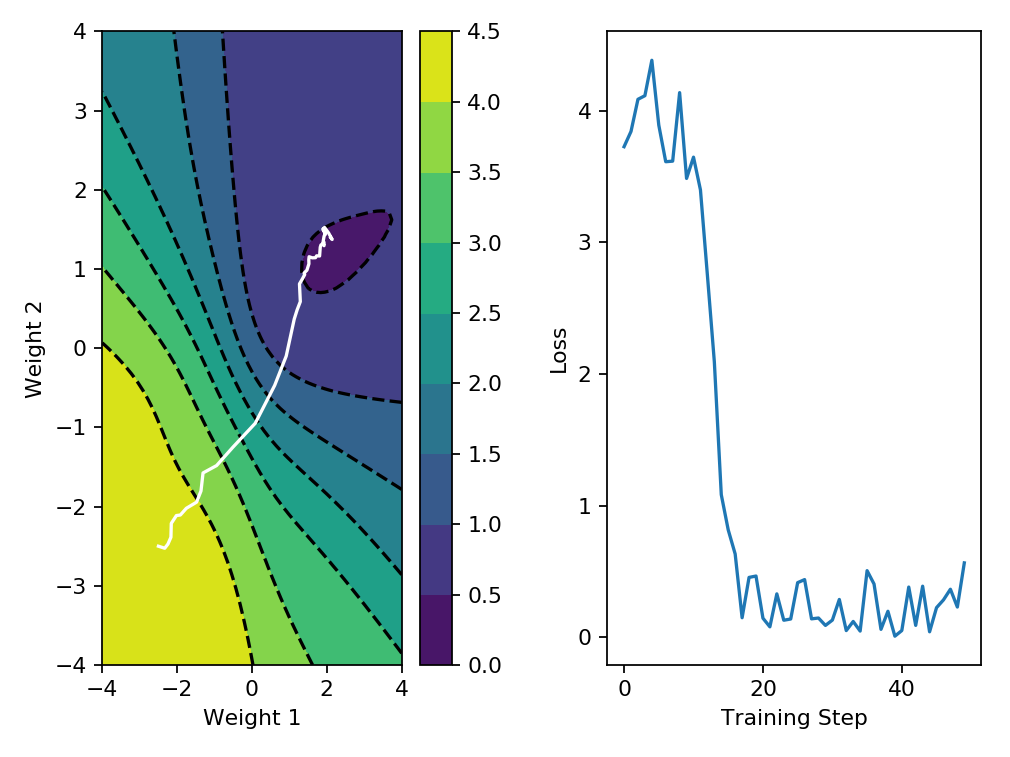

In [11]:
# Init weights
weights = np.array([[-2.5, -2.5]]).T

# Plot buffers
losses = np.zeros(training_steps)
weights_history = np.zeros((training_steps, 2))

fig, axs = plt.subplots(1, 2)

for training_step in range(training_steps):
    if batch_type == "batch":
        random_indices = range(sample_size * 2)
        learning_rate = 0.1
    elif batch_type == "mini-batch":
        mini_batch_size = 10
        random_indices = np.random.choice(sample_size * 2, mini_batch_size, replace = False)
        learning_rate = 0.5
    elif batch_type == "stochastic":
        random_indices = np.random.choice(sample_size * 2, 1, replace = False)
        learning_rate = 2.5
    
    # Create batch
    batch = cats_and_dogs[:, random_indices]
    batch_labels = labels[random_indices]
    
    # Forward- and backpropagate
    y, losses[training_step], gradient = propagate(batch, batch_labels, weights)
    
    # Create surface plot
    X, Y, surface = error_surface(batch, batch_labels)
    
    ax = axs[0]
    ax.cla()
    cp = ax.contourf(X, Y, surface, cmap = "viridis")
    ax.contour(X, Y, surface, colors = "black", linestyles = "dashed")
    if training_step == 0:
        plt.sca(ax)
        plt.colorbar(cp)
    
    ax.set_xlabel('Weight 1')
    ax.set_ylabel('Weight 2')
    
    ax.plot(weights_history[:training_step, 0], weights_history[:training_step, 1], 'w-')
    
    # Plot loss
    ax = axs[1]
    ax.cla()
    ax.plot(losses)
    ax.set_xlabel('Training Step')
    ax.set_ylabel('Loss')
    
    fig.canvas.draw()
    if training_step == 0:
        fig.tight_layout()
    
    # Update weights
    weights_history[training_step, :] = weights[:,0]
    if not momentum:
        weights -= learning_rate * gradient
    else:
        weights -= (beta*last_gradient) + (learning_rate * gradient)
        last_gradient = gradient
    
    sleep(0.2)
    